In [89]:
import matplotlib
import tensorflow as tf
import tensorflow_datasets as tfds
import random
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import *

In [90]:
matplotlib.rcParams['figure.figsize'] = [10, 7]

# Hyperparameters
seed = 22
tf.random.set_seed(seed)
random.seed(a=seed)
hidden_neurons = 128
number_of_hidden_layers = 1
batch_size = 128
learning_rate = 0.001
max_epochs = 50

In [91]:
def plot_metric(history_data):
    train_metrics = history_data.history['accuracy']
    for t in range(train_metrics.__len__()):
        train_metrics[t] = 1 - train_metrics[t]
    val_metrics = history_data.history['val_' + 'accuracy']
    for t in range(val_metrics.__len__()):
        val_metrics[t] = 1 - val_metrics[t]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation ' + 'errors')
    plt.xlabel("Epochs")
    plt.ylabel('Percentage of errors')
    plt.legend(["train_" + 'errors', 'val_' + 'errors'])
    plt.show()

In [108]:
def print_optimal():
    print("Optimal Hyperparameters")
    print("Seed used: ", seed)
    print("batch size: ", batch_size)
    print("Number of hidden layers: ", number_of_hidden_layers)
    print("Hidden layer number of neurons: ", hidden_neurons)
    print("Learning rate: ", learning_rate)
    print("Max epochs: ", max_epochs)

In [93]:
def plot_matrix(matrix):
    plot_confusion_matrix(matrix)
    plt.show()

In [94]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [114]:
def accuracy_score(y_pred, y):
    is_equal = tf.equal(y_pred, y)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [159]:
def print_accuracy_by_digit(y_test, test_classes, result_to_print):
    print("Accuracy breakdown by digit:")
    print("---------------------------")
    array = []
    label_accs = {}
    for label in range(10):
        label_ind = (y_test == label)
        pred_label = test_classes[label_ind]
        label_filled = tf.cast(tf.fill(pred_label.shape[0], label), tf.int64)
        label_accs[accuracy_score(pred_label, label_filled).numpy()] = label
    for key in label_accs:
        print(f"Digit {label_accs[key]}: {key:.3f}")
    print(f"Total accuracy: {result_to_print[1]:.3f}")

In [95]:
(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

In [96]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [97]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [98]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [99]:
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [100]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(hidden_neurons, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [101]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [102]:
history = model.fit(ds_train, epochs=max_epochs, validation_data=ds_test)

Epoch 1/50
469/469 [==============================] - 8s 12ms/step - loss: 0.3639 - accuracy: 0.9003 - val_loss: 0.1979 - val_accuracy: 0.9443
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1724 - accuracy: 0.9505 - val_loss: 0.1443 - val_accuracy: 0.9581
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1248 - accuracy: 0.9642 - val_loss: 0.1245 - val_accuracy: 0.9624
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0971 - accuracy: 0.9712 - val_loss: 0.1020 - val_accuracy: 0.9696
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0772 - accuracy: 0.9779 - val_loss: 0.0924 - val_accuracy: 0.9726
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.9815 - val_loss: 0.0894 - val_accuracy: 0.9731
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0535 - accuracy: 0.9841 - val_loss: 0.0775 - val_accuracy: 0.9756
Epoch

In [103]:
test_result = model.evaluate(ds_test)

79/79 [==============================] - 0s 4ms/step - loss: 0.1111 - accuracy: 0.9786


In [104]:
predictions = model.predict(ds_test)

79/79 [==============================] - 0s 3ms/step


In [109]:
print_optimal()

Optimal Hyperparameters
Seed used:  22
batch size:  128
Number of hidden layers:  1
Hidden layer number of neurons:  128
Learning rate:  0.001
Max epochs:  50


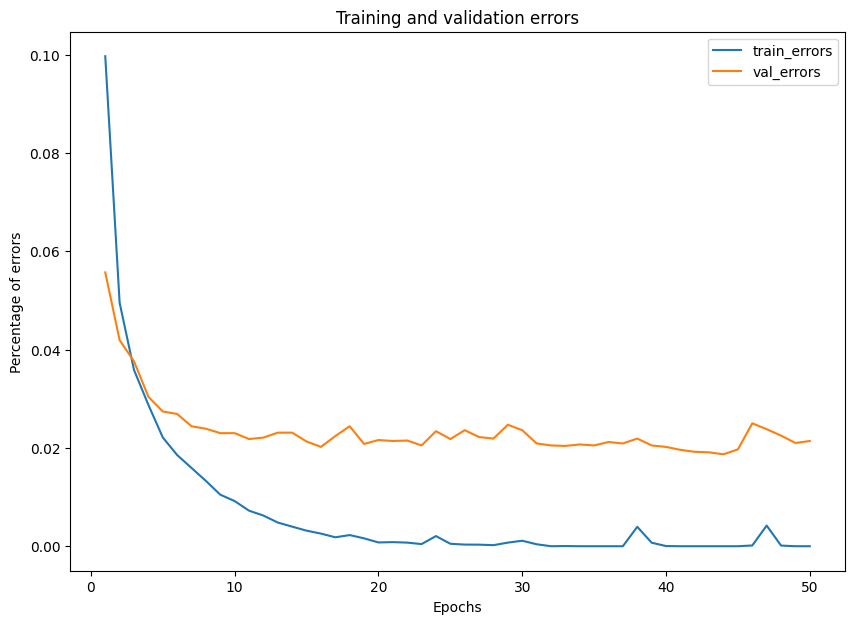

In [110]:
plot_metric(history)

In [111]:
test_y = np.concatenate([y for x, y in ds_test], axis=0)

In [131]:
true_predictions = predictions.argmax(axis=1)

In [160]:
print_accuracy_by_digit(test_y, true_predictions, test_result)

Accuracy breakdown by digit:
---------------------------
Digit 0: 0.990
Digit 1: 0.991
Digit 2: 0.975
Digit 3: 0.980
Digit 4: 0.982
Digit 5: 0.974
Digit 6: 0.978
Digit 7: 0.978
Digit 8: 0.967
Digit 9: 0.969
Total accuracy: 0.979


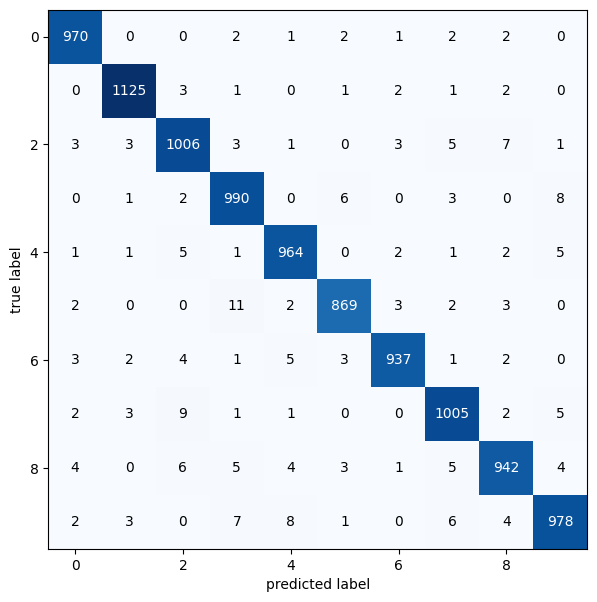

In [162]:
result = confusion_matrix(test_y, true_predictions)
plot_matrix(result)